# Data Science Project imporvement, using LightGBM to gain more accuracy and no need to One-Hot Encoding
> Using LightGBM native categorical feature support for Adult Dataset 

- toc: true 
- badges: true
- comments: true
- categories: [LightGBM]


# Overview

We have done the last Data Science Project with U.S. Adult Income Dataset with around `86%` model accuracy, which can go into the top level accuracy in [Kaggle](https://www.kaggle.com) competition. we have done the following steps: 

1. Understand the business problem. 
2. EDA(Exploratory Data Analysis): Look through and investigate the overall dataset, visualize it with matplotlib and finding any missing value and outliers. 
3. Data cleaning: impute the missing and outliers value. 
4. Baseline model: Dummy classifier gave us `75%` accuracy as baseline, meaning that anything below `75%` accuracy, the model do nothing better than flipping a coin, and above this value, the model have some skill to classify the labels. 
5. Model evaluate and fine turn: we have evaluate `Support Vector Machine`; `RamdonForestClassifier`; `BaggingClassifier`; `GradientBoostingClassifier` and `Neural Network`, the best performance model is `GradientBoostingClassifier` which providing `86%` of accuracy. 

Today we are going to use another light weight, powerful, and fast algorithem: [lightGBM](https://github.com/microsoft/LightGBM), open source at 2017, and now maintainced by [Microsoft](https://www.microsoft.com/en-sg)

As the `EDA` was already done by the last blog, we will just skip it and move directly into today's topic.


# Get the imports done and read the dataset
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datasets/adult.csv', na_values="?")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


# Data Cleaning part: Scaled the numerical column, and Label encoding the binary categorical column
***

* The target column `income` need to be encoded as `1` and `0`
* As well as the `gender` column

In [4]:
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

num_col = df.select_dtypes(exclude=['object', 'datetime']).columns
df[num_col] = scaler.fit_transform(df[num_col])

In [5]:
le = LabelEncoder()

df['gender'] = le.fit_transform(df['gender'])
df['income'] = le.fit_transform(df['income'])

In [6]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.109589,Private,0.145129,11th,0.400000,Never-married,Machine-op-inspct,Own-child,Black,1,0.000000,0.0,0.397959,United-States,0
1,0.287671,Private,0.052451,HS-grad,0.533333,Married-civ-spouse,Farming-fishing,Husband,White,1,0.000000,0.0,0.500000,United-States,0
2,0.150685,Local-gov,0.219649,Assoc-acdm,0.733333,Married-civ-spouse,Protective-serv,Husband,White,1,0.000000,0.0,0.397959,United-States,1
3,0.369863,Private,0.100153,Some-college,0.600000,Married-civ-spouse,Machine-op-inspct,Husband,Black,1,0.076881,0.0,0.397959,United-States,1
4,0.013699,NaN,0.061708,Some-college,0.600000,Never-married,NaN,Own-child,White,0,0.000000,0.0,0.295918,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.136986,Private,0.165763,Assoc-acdm,0.733333,Married-civ-spouse,Tech-support,Wife,White,0,0.000000,0.0,0.377551,United-States,0
48838,0.315068,Private,0.096129,HS-grad,0.533333,Married-civ-spouse,Machine-op-inspct,Husband,White,1,0.000000,0.0,0.397959,United-States,1
48839,0.561644,Private,0.094462,HS-grad,0.533333,Widowed,Adm-clerical,Unmarried,White,0,0.000000,0.0,0.397959,United-States,0
48840,0.068493,Private,0.128004,HS-grad,0.533333,Never-married,Adm-clerical,Own-child,White,1,0.000000,0.0,0.193878,United-States,0


## Data Cleaning Part: Impute the missing value
***

The missing value are all fall into categorical features

In [7]:
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

Impute the missing value with the most frequent value

In [8]:
df = df.fillna(df.mode().iloc[0])

In [9]:
df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

## Data Cleaning Part: Convert the `object` Data type into `category` Data type
***

LightGBM can handle the `category` feature by itself, but before that, we need to convert the `object` dtype to `category` dtype, so that LightGBM can handle it. 

In [10]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  float64 
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  float64 
 3   education        48842 non-null  category
 4   educational-num  48842 non-null  float64 
 5   marital-status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  int64   
 10  capital-gain     48842 non-null  float64 
 11  capital-loss     48842 non-null  float64 
 12  hours-per-week   48842 non-null  float64 
 13  native-country   48842 non-null  category
 14  income           48842 non-null  int64   
dtypes: category(7), float64(6), int64(2)
memory usage: 3.3 MB


# Modeling Part
***

In [12]:
X = df.drop('income', axis=1)
y = df['income']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [14]:
clf = lgb.LGBMClassifier(objective='binary', silent=False, colsample_bytree=0.9, subsample=0.9, learning_rate=0.05)

In [15]:
fit_params = {
    'early_stopping_rounds': 10,
    'eval_metric': 'accuracy',
    'eval_set': [(X_test, y_test)],
    'eval_names': ['valid'], 
    'verbose': 100,
    'feature_name': 'auto', # actually this is default
    'categorical_feature': 'auto' # actually this is default
}

In [16]:
clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
[100]	valid's binary_logloss: 0.2779
Did not meet early stopping. Best iteration is:
[100]	valid's binary_logloss: 0.2779


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [17]:
print(f"The Model Accuracy: {(clf.score(X_test, y_test)*100):.2f}%")

The Model Accuracy: 87.53%


## Accuracy imporvement
***

Compare to last blog, the best performing model: `GradientBoostingClassifier` have achieved around `86%` of Accuracy, here using LightGBM, without One-Hot Encoding the categorical feature, it have around `1%` of Accuracy improving. 

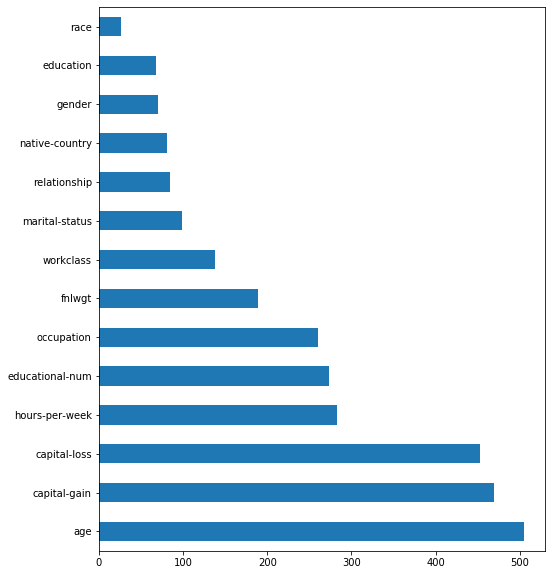

In [18]:
%matplotlib inline
feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

## Feature Importance
***

LightGBM has built-in Feature Importance examination, it shows clearly in the plot, the `age` and `capital-gain` feature is the most important features that impact the `income` target.  